```
This software is part of GPU Ocean. 

Copyright (C) 2024 SINTEF Digital

Minimalistic example for running the simplified ocean model nested
within the forecast produced by an operational 3D ocean model.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Florian PhD thesis

Based on https://github.com/havahol/miscGPUOcean/blob/main/demos/demo-deterministicSimulation.ipynb

In [15]:
# Load required modules
%matplotlib inline

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl

import numpy as np

import copy

In [16]:
# Import relevant modules from within GPU Ocean
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import IPythonMagic, NetCDFInitialization, PlotHelper

In [17]:
# Create the GPU context
%cuda_context_handler gpu_ctx

In [18]:
# Url or path to operational ocean forecast
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

# Use a predefined subdomain
casename = 'lofoten'

# Load initial and boundary conditions, bathymetry, landmask, forcing, etc
sim_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url, casename)

In [19]:
domain_extent = [0, sim_args["nx"]*sim_args["dx"]/1000, 0, sim_args["ny"]*sim_args["dy"]/1000]

In [20]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [21]:
lat = np.array(nc.variables["lat"][452:748, 1402:1898])
lon = np.array(nc.variables["lon"][452:748, 1402:1898])

## Vorticity

In [22]:
T_hours = 3

In [23]:
vor_cmap = copy.copy(plt.cm.seismic)
vor_cmap.set_bad(color='grey')

In [24]:
vmax=0.75
R_min = -vmax/2500
R_max = vmax/2500

In [25]:
coarse_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 0.5)

coarse_sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, **NetCDFInitialization.removeMetadata(coarse_sim_args))
coarse_sim.step(T_hours*3600)

coarse_eta, coarse_hu, coarse_hv = coarse_sim.download(interior_domain_only=True)
_, coarse_Hm = coarse_sim.downloadBathymetry(interior_domain_only=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [26]:
coarse_R = PlotHelper.genColors(coarse_Hm+coarse_eta, coarse_hu/coarse_sim.dx, coarse_hv/coarse_sim.dy, vor_cmap, R_min, R_max)

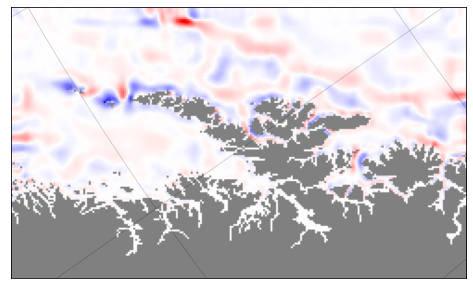

In [27]:
plt.figure(figsize=(10,5))
plt.imshow(coarse_R, origin="lower", extent=domain_extent)

plt.contour(lon, levels = np.arange(0, 90, 5.0), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(lat, levels = np.arange(0, 90, 2.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_1600.pdf", dpi=600, bbox_inches="tight")

In [29]:
sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, **NetCDFInitialization.removeMetadata(sim_args))
sim.step(T_hours*3600)

eta, hu, hv = sim.download(interior_domain_only=True)

C:\Users\florianb\Documents\havvarsel\gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:214: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [30]:
R = PlotHelper.genColors(Hm+eta, hu/sim.dx, hv/sim.dy, vor_cmap, R_min, R_max)


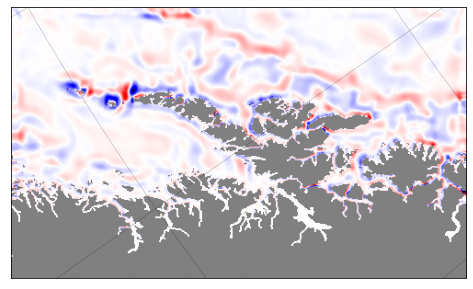

In [31]:
plt.figure(figsize=(10,5))
plt.imshow(R, origin="lower", extent=domain_extent)

plt.contour(lon, levels = np.arange(0, 90, 5.0), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(lat, levels = np.arange(0, 90, 2.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_800.pdf", dpi=600, bbox_inches="tight")

In [32]:
fine_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 2)

fine_sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, **NetCDFInitialization.removeMetadata(fine_sim_args))
fine_sim.step(T_hours*3600)

fine_eta, fine_hu, fine_hv = fine_sim.download(interior_domain_only=True)
_, fine_Hm = fine_sim.downloadBathymetry(interior_domain_only=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [33]:
fine_R = PlotHelper.genColors(fine_Hm+fine_eta, fine_hu/fine_sim.dx, fine_hv/fine_sim.dy, vor_cmap, R_min, R_max)

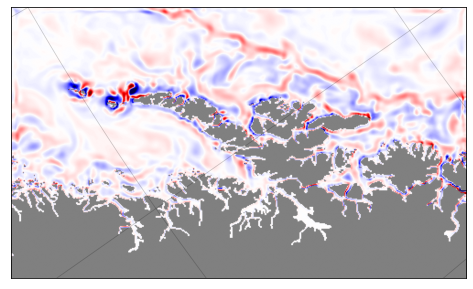

In [34]:
plt.figure(figsize=(10,5))
plt.imshow(fine_R, origin="lower", extent=domain_extent)

plt.contour(lon, levels = np.arange(0, 90, 5.0), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(lat, levels = np.arange(0, 90, 2.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_400.pdf", dpi=600, bbox_inches="tight")

In [35]:
extra_fine_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 4)

extra_fine_sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, **NetCDFInitialization.removeMetadata(extra_fine_sim_args))
extra_fine_sim.step(T_hours*3600)

extra_fine_eta, extra_fine_hu, extra_fine_hv = extra_fine_sim.download(interior_domain_only=True)
_, extra_fine_Hm = extra_fine_sim.downloadBathymetry(interior_domain_only=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [36]:
extra_fine_R = PlotHelper.genColors(extra_fine_Hm+extra_fine_eta, extra_fine_hu/extra_fine_sim.dx, extra_fine_hv/extra_fine_sim.dy, vor_cmap, R_min, R_max)

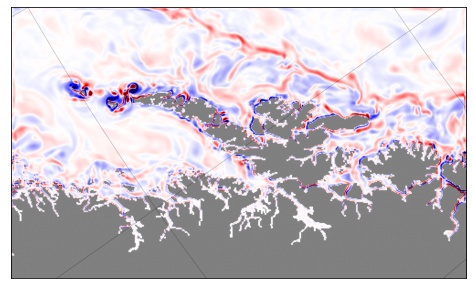

In [37]:
plt.figure(figsize=(10,5))
plt.imshow(extra_fine_R, origin="lower", extent=domain_extent)

plt.contour(lon, levels = np.arange(0, 90, 5.0), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(lat, levels = np.arange(0, 90, 2.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_200.pdf", dpi=600, bbox_inches="tight")

In [33]:
nc.variables.keys()

dict_keys(['Cs_r', 'Cs_w', 'X', 'Y', 'depth', 'forecast_reference_time', 'hc', 'projection_stere', 'time', 'AKs', 'Uwind', 'Vwind', 'angle', 'h', 'lat', 'lon', 'salinity', 'temperature', 'tke', 'u', 'u_eastward', 'ubar', 'v', 'v_northward', 'vbar', 'w', 'zeta'])

In [38]:
op_h = nc["h"][452:748, 1402:1898] + nc["zeta"][T_hours][452:748, 1402:1898]
op_hu = nc["ubar"][T_hours][452:748, 1402:1898] * op_h
op_hv = nc["vbar"][T_hours][452:748, 1402:1898] * op_h

op_R = PlotHelper.genColors(op_h, op_hu/800, op_hv/800, vor_cmap, R_min, R_max)

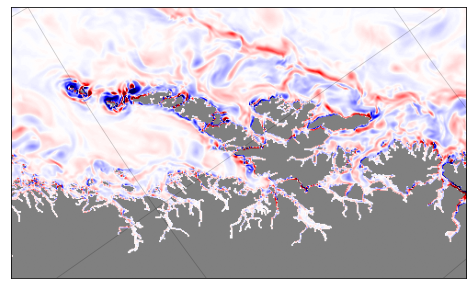

In [39]:
plt.figure(figsize=(10,5))
plt.imshow(op_R, origin="lower", extent=domain_extent)

plt.contour(lon, levels = np.arange(0, 90, 5.0), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
plt.contour(lat, levels = np.arange(0, 90, 2.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

plt.xticks([])
plt.yticks([])
plt.savefig("Vorticity_operational.pdf", dpi=600, bbox_inches="tight")